In [1]:
import fingerprint_enhancer  # Load the library
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

from PIL import Image, ImageOps
import matplotlib.pyplot as plot
from matplotlib.ticker import NullFormatter
from matplotlib.gridspec import GridSpec
from matplotlib import offsetbox

import h5py, pickle
from random import randint, choice, shuffle, sample
from itertools import product

from scipy import signal 

import os, os.path
import pandas as pd
import math

import warnings
warnings.filterwarnings('ignore')

# folder = "E:\BTP\SOCOFing\Real"
folder = "E:\BTP\SOCOFing\Test"
# alt_folder = "E:\BTP\SOCOFing\AltTest"
alt_folder = "E:\BTP\SOCOFing\Test"

In [2]:
from scipy import ndimage
import scipy

class FingerprintImageEnhancer(object):
    def __init__(self):
        self.ridge_segment_blksze = 16
        self.ridge_segment_thresh = 0.1
        self.gradient_sigma = 1
        self.block_sigma = 7
        self.orient_smooth_sigma = 7
        self.ridge_freq_blksze = 38
        self.ridge_freq_windsze = 5
        self.min_wave_length = 5
        self.max_wave_length = 15
        self.kx = 0.65
        self.ky = 0.65
        self.angleInc = 3
        self.ridge_filter_thresh = -3


        self._mask = []
        self._normim = []
        self._orientim = []
        self._mean_freq = []
        self._median_freq = []
        self._freq = []
        self._freqim = []
        self._binim = []

    def __normalise(self, img, mean, std):
        if(np.std(img) == 0):
            raise ValueError("Image standard deviation is 0. Please review image again")
        normed = (img - np.mean(img)) / (np.std(img))
        return (normed)

    def __ridge_segment(self, img):
        # RIDGESEGMENT - Normalises fingerprint image and segments ridge region
        #
        # Function identifies ridge regions of a fingerprint image and returns a
        # mask identifying this region.  It also normalises the intesity values of
        # the image so that the ridge regions have zero mean, unit standard
        # deviation.
        #
        # This function breaks the image up into blocks of size blksze x blksze and
        # evaluates the standard deviation in each region.  If the standard
        # deviation is above the threshold it is deemed part of the fingerprint.
        # Note that the image is normalised to have zero mean, unit standard
        # deviation prior to performing this process so that the threshold you
        # specify is relative to a unit standard deviation.
        #
        # Usage:   [normim, mask, maskind] = ridgesegment(im, blksze, thresh)
        #
        # Arguments:   im     - Fingerprint image to be segmented.
        #              blksze - Block size over which the the standard
        #                       deviation is determined (try a value of 16).
        #              thresh - Threshold of standard deviation to decide if a
        #                       block is a ridge region (Try a value 0.1 - 0.2)
        #
        # Ouput:     normim - Image where the ridge regions are renormalised to
        #                       have zero mean, unit standard deviation.
        #              mask   - Mask indicating ridge-like regions of the image,
        #                       0 for non ridge regions, 1 for ridge regions.
        #              maskind - Vector of indices of locations within the mask.
        #
        # Suggested values for a 500dpi fingerprint image:
        #
        #   [normim, mask, maskind] = ridgesegment(im, 16, 0.1)
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk
        rows, cols = img.shape
        im = self.__normalise(img, 0, 1)  # normalise to get zero mean and unit standard deviation

        new_rows = np.int(self.ridge_segment_blksze * np.ceil((np.float(rows)) / (np.float(self.ridge_segment_blksze))))
        new_cols = np.int(self.ridge_segment_blksze * np.ceil((np.float(cols)) / (np.float(self.ridge_segment_blksze))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = im
        for i in range(0, new_rows, self.ridge_segment_blksze):
            for j in range(0, new_cols, self.ridge_segment_blksze):
                block = padded_img[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze]

                stddevim[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        self._mask = stddevim > self.ridge_segment_thresh
        mean_val = np.mean(im[self._mask])
        std_val = np.std(im[self._mask])
        self._normim = (im - mean_val) / (std_val)

    def __ridge_orient(self):
        # RIDGEORIENT - Estimates the local orientation of ridges in a fingerprint
        #
        # Usage:  [orientim, reliability, coherence] = ridgeorientation(im, gradientsigma,...
        #                                             blocksigma, ...
        #                                             orientsmoothsigma)
        #
        # Arguments:  im                - A normalised input image.
        #             gradientsigma     - Sigma of the derivative of Gaussian
        #                                 used to compute image gradients.
        #             blocksigma        - Sigma of the Gaussian weighting used to
        #                                 sum the gradient moments.
        #             orientsmoothsigma - Sigma of the Gaussian used to smooth
        #                                 the final orientation vector field.
        #                                 Optional: if ommitted it defaults to 0
        #
        # Output:    orientim          - The orientation image in radians.
        #                                 Orientation values are +ve clockwise
        #                                 and give the direction *along* the
        #                                 ridges.
        #             reliability       - Measure of the reliability of the
        #                                 orientation measure.  This is a value
        #                                 between 0 and 1. I think a value above
        #                                 about 0.5 can be considered 'reliable'.
        #                                 reliability = 1 - Imin./(Imax+.001);
        #             coherence         - A measure of the degree to which the local
        #                                 area is oriented.
        #                                 coherence = ((Imax-Imin)./(Imax+Imin)).^2;
        #
        # With a fingerprint image at a 'standard' resolution of 500dpi suggested
        # parameter values might be:
        #
        #    [orientim, reliability] = ridgeorient(im, 1, 3, 3);
        #
        # See also: RIDGESEGMENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # May 2003      Original version by Raymond Thai,
        # January 2005  Reworked by Peter Kovesi
        # October 2011  Added coherence computation and orientsmoothsigma made optional
        #
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows,cols = self._normim.shape
        #Calculate image gradients.
        sze = np.fix(6*self.gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv2.getGaussianKernel(np.int(sze),self.gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)                               #Gradient of Gaussian

        Gx = signal.convolve2d(self._normim, fx, mode='same')
        Gy = signal.convolve2d(self._normim, fy, mode='same')

        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*self.block_sigma)

        gauss = cv2.getGaussianKernel(np.int(sze), self.block_sigma)
        f = gauss * gauss.T

        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom


        if self.orient_smooth_sigma:
            sze = np.fix(6*self.orient_smooth_sigma)
            if np.remainder(sze,2) == 0:
                sze = sze+1
            gauss = cv2.getGaussianKernel(np.int(sze), self.orient_smooth_sigma)
            f = gauss * gauss.T
            cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
            sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        self._orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2

    def __ridge_freq(self):
        # RIDGEFREQ - Calculates a ridge frequency image
        #
        # Function to estimate the fingerprint ridge frequency across a
        # fingerprint image. This is done by considering blocks of the image and
        # determining a ridgecount within each block by a call to FREQEST.
        #
        # Usage:
        #  [freqim, medianfreq] =  ridgefreq(im, mask, orientim, blksze, windsze, ...
        #                                    minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         mask     - Mask defining ridge regions (obtained from RIDGESEGMENT)
        #         orientim - Ridge orientation image (obtained from RIDGORIENT)
        #         blksze   - Size of image block to use (say 32)
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim     - An image  the same size as im with  values set to
        #                      the estimated ridge spatial frequency within each
        #                      image block.  If a  ridge frequency cannot be
        #                      found within a block, or cannot be found within the
        #                      limits set by min and max Wavlength freqim is set
        #                      to zeros within that block.
        #         medianfreq - Median frequency value evaluated over all the
        #                      valid regions of the image.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   [freqim, medianfreq] = ridgefreq(im,orientim, 32, 5, 5, 15);
        #

        # See also: RIDGEORIENT, FREQEST, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = self._normim.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - self.ridge_freq_blksze, self.ridge_freq_blksze):
            for c in range(0, cols - self.ridge_freq_blksze, self.ridge_freq_blksze):
                blkim = self._normim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]
                blkor = self._orientim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]

                freq[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze] = self.__frequest(blkim, blkor)

        self._freq = freq * self._mask
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        self._mean_freq = np.mean(non_zero_elems_in_freq)
        self._median_freq = np.median(non_zero_elems_in_freq)  # does not work properly

        self._freq = self._mean_freq * self._mask

    def __frequest(self, blkim, blkor):
        # FREQEST - Estimate fingerprint ridge frequency within image block
        #
        # Function to estimate the fingerprint ridge frequency within a small block
        # of a fingerprint image.  This function is used by RIDGEFREQ
        #
        # Usage:
        #  freqim =  freqest(im, orientim, windsze, minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image block to be processed.
        #         orientim - Ridge orientation image of image block.
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim    - An image block the same size as im with all values
        #                     set to the estimated ridge spatial frequency.  If a
        #                     ridge frequency cannot be found, or cannot be found
        #                     within the limits set by min and max Wavlength
        #                     freqim is set to zeros.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   freqim = freqest(im,orientim, 5, 5, 15);
        #
        # See also:  RIDGEFREQ, RIDGEORIENT, RIDGESEGMENT

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = np.shape(blkim)

        # Find mean orientation within the block. This is done by averaging the
        # sines and cosines of the doubled angles before reconstructing the
        # angle again.  This avoids wraparound problems at the origin.

        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        # Rotate the image block so that the ridges are vertical

        # ROT_mat = cv2.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)
        # rotim = cv2.warpAffine(im,ROT_mat,(cols,rows))
        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        # Now crop the image so that the rotated image does not contain any
        # invalid regions.  This prevents the projection down the columns
        # from being mucked up.

        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        # Sum down the columns to get a projection of the grey values down
        # the ridges.

        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, self.ridge_freq_windsze, structure=np.ones(self.ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        # Determine the spatial frequency of the ridges by divinding the
        # distance between the 1st and last peaks by the (No of peaks-1). If no
        # peaks are detected, or the wavelength is outside the allowed bounds,
        # the frequency image is set to 0

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= self.min_wave_length and waveLength <= self.max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

    def __ridge_filter(self):
        # RIDGEFILTER - enhances fingerprint image via oriented filters
        #
        # Function to enhance fingerprint image via oriented filters
        #
        # Usage:
        #  newim =  ridgefilter(im, orientim, freqim, kx, ky, showfilter)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         orientim - Ridge orientation image, obtained from RIDGEORIENT.
        #         freqim   - Ridge frequency image, obtained from RIDGEFREQ.
        #         kx, ky   - Scale factors specifying the filter sigma relative
        #                    to the wavelength of the filter.  This is done so
        #                    that the shapes of the filters are invariant to the
        #                    scale.  kx controls the sigma in the x direction
        #                    which is along the filter, and hence controls the
        #                    bandwidth of the filter.  ky controls the sigma
        #                    across the filter and hence controls the
        #                    orientational selectivity of the filter. A value of
        #                    0.5 for both kx and ky is a good starting point.
        #         showfilter - An optional flag 0/1.  When set an image of the
        #                      largest scale filter is displayed for inspection.
        #
        # Output:
        #         newim    - The enhanced image
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        im = np.double(self._normim)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))

        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        # Round the array of frequencies to the nearest 0.01 to reduce the
        # number of distinct frequencies we have to deal with.

        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100

        unfreq = np.unique(non_zero_elems_in_freq)

        # Generate filters corresponding to these distinct frequencies and
        # orientations in 'angleInc' increments.

        sigmax = 1 / unfreq[0] * self.kx
        sigmay = 1 / unfreq[0] * self.ky

        sze = np.int(np.round(3 * np.max([sigmax, sigmay])))

        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)        # this is the original gabor filter

        filt_rows, filt_cols = reffilter.shape

        angleRange = np.int(180 / self.angleInc)

        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):
            # Generate rotated versions of the filter.  Note orientation
            # image provides orientation *along* the ridges, hence +90
            # degrees, and imrotate requires angles +ve anticlockwise, hence
            # the minus sign.

            rot_filt = scipy.ndimage.rotate(reffilter, -(o * self.angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # Find indices of matrix points greater than maxsze from the image
        # boundary

        maxsze = int(sze)

        temp = self._freq > 0
        validr, validc = np.where(temp)

        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze

        final_temp = temp1 & temp2 & temp3 & temp4

        finalind = np.where(final_temp)

        # Convert orientation matrix values from radians to an index value
        # that corresponds to round(degrees/angleInc)

        maxorientindex = np.round(180 / self.angleInc)
        orientindex = np.round(self._orientim / np.pi * 180 / self.angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        self._binim = newim < self.ridge_filter_thresh

    def save_enhanced_image(self, path):
        # saves the enhanced image at the specified path
        cv2.imwrite(path, (255 * self._binim))

    def enhance(self, img, resize=True):
        # main function to enhance the image.
        # calls all other subroutines

        if(resize):
            rows, cols = np.shape(img)
            aspect_ratio = np.double(rows) / np.double(cols)

            new_rows = 350                      # randomly selected number
            new_cols = new_rows / aspect_ratio

            img = cv2.resize(img, (np.int(new_cols), np.int(new_rows)))

        self.__ridge_segment(img)   # normalise the image and find a ROI
        self.__ridge_orient()       # compute orientation image
        self.__ridge_freq()         # compute major frequency of ridges
        self.__ridge_filter()       # filter the image using oriented gabor filter
        return(self._binim)

In [3]:
%%capture --no-display

SIFT_DATA = []

#   sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()
image_enhancer = FingerprintImageEnhancer() 

for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
#     plt.imshow(img,cmap='gray')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # print(np.shape(img))
    img = image_enhancer.enhance(img)
    img = np.array(img, dtype=np.uint8)*255
    
    keypoints_1, descriptors_1 = sift.detectAndCompute(img, None)
    
    SIFT_DATA.append([filename, keypoints_1, descriptors_1])

In [4]:
num = random.randint(0, len(os.listdir(alt_folder)))
sample_filename = os.listdir(alt_folder)[num]
sample_img = cv2.imread(os.path.join(alt_folder,sample_filename))

bestscore = 0
result = None
mp = None
results = []

The images on the left side is the image that is trying to be found. And the image on the right side is the image that the algorithm matches the left side image in database. In this code first all the feature points of the images are being extracted and are stored in a variable after that we are manually searching for the bestmatch. this taken O(n) time for one image.
### Matching images without any transformation. 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
11 11
 Score: 100.0


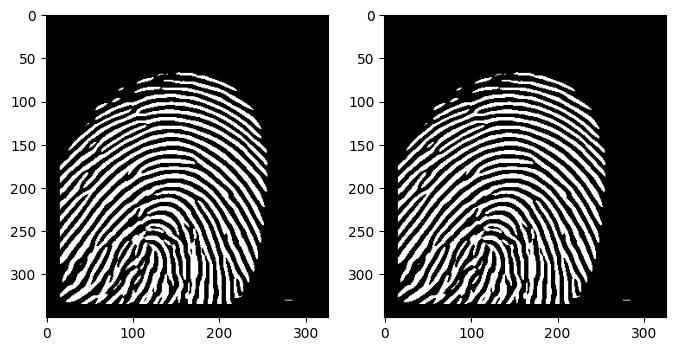

In [5]:
# sample_img = fingerprint_enhancer.enhance_Fingerprint(sample_img)
sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2GRAY)
sample_img = image_enhancer.enhance(sample_img)
sample_img = np.array(sample_img, dtype=np.uint8)*255
keypoints_2, descriptors_2 = sift.detectAndCompute(sample_img, None)

for i in range(len(SIFT_DATA)):
#     print(result)

    matches = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10),
                                    dict()).knnMatch(SIFT_DATA[i][2], descriptors_2, k=2)
    match_points = []
    for p, q in matches:
        if p.distance < 0.1*q.distance:
            match_points.append(p)

    keypoints = min(len(SIFT_DATA[i][1]), len(keypoints_2))
    results.append(len(match_points)/keypoints*100)
    if len(match_points)/keypoints*100 > bestscore:
        bestscore = len(match_points)/keypoints*100
        result, mp = i, match_points

print(results)
print(str(result) + " " + str(num))
print(" Score: " + str(bestscore))

out = cv2.imread(os.path.join(folder, SIFT_DATA[result][0]))
out = cv2.cvtColor(out,cv2.COLOR_BGR2GRAY)
out = image_enhancer.enhance(out)
out = np.array(out, dtype=np.uint8)*255
f = plt.figure(figsize=(8,4))
sp = f.add_subplot(1, 2, 1)
plt.imshow(sample_img,cmap='gray')
sp = f.add_subplot(1, 2, 2)
plt.imshow(out,cmap='gray')

### Shifting Images and matching it

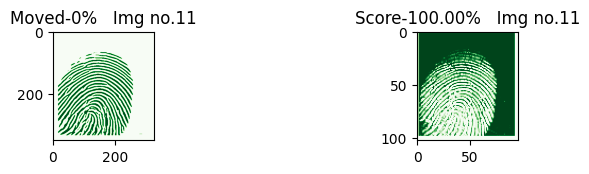

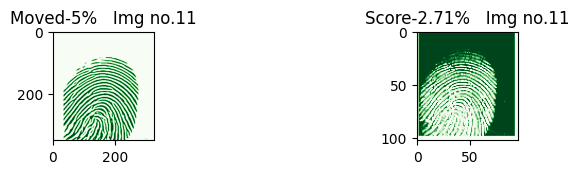

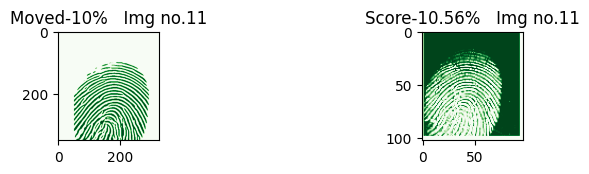

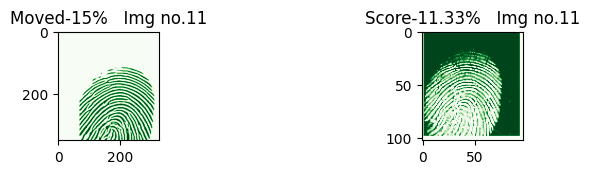

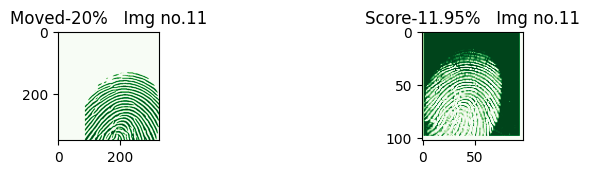

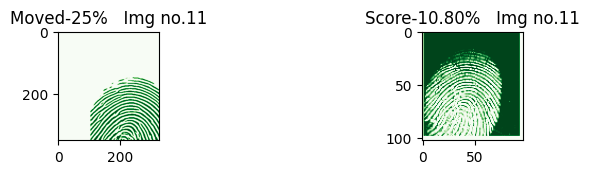

In [6]:
rows,cols = sample_img.shape[0], sample_img.shape[1]

for j in range(0, 26, 5):
    
    bestscore = -1
    result = None
    
    M = np.float32([[1,0,rows*(j/100)],[0,1,cols*(j/100)]])
    
    changed_img = cv2.warpAffine(sample_img,M,(cols,rows))
    keypoints_2, descriptors_2 = sift.detectAndCompute(changed_img, None)
    c_map = None 

    for i in range(len(SIFT_DATA)):
        matches = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10),
                                        dict()).knnMatch(SIFT_DATA[i][2], descriptors_2, k=2)
        match_points = []
        for p, q in matches:
            if p.distance < 0.1*q.distance:
                match_points.append(p)

        keypoints = min(len(SIFT_DATA[i][1]), len(keypoints_2))
        if len(match_points)/keypoints*100 > bestscore:
            bestscore = len(match_points)/keypoints*100
            result = i
    
#     print(" Score: " + str(bestscore) + " " + str(result) + " " + str(num))
    if result==num : 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
        
    out = cv2.imread(os.path.join(folder, SIFT_DATA[result][0]))
#     out = cv2.cvtColor(out,cv2.COLOR_BGR2GRAY)
#     out = image_enhancer.enhance(out)
#     out = np.array(out, dtype=np.uint8)*255
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
#     plt.imshow(cv2.cvtColor(changed_img, cv2.COLOR_BGR2GRAY),cmap=c_map)
    plt.title("Moved-{}%   Img no.{}".format(j, num))
    plt.imshow(changed_img ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(bestscore)+str(result))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY),cmap=c_map)

### Rotating Images and matching it

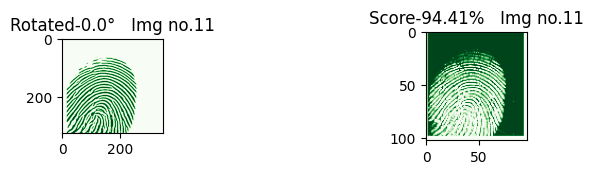

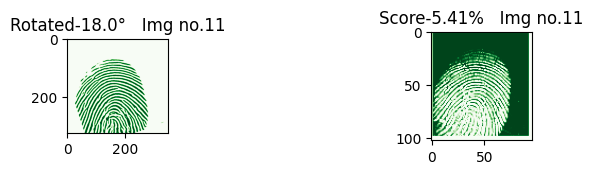

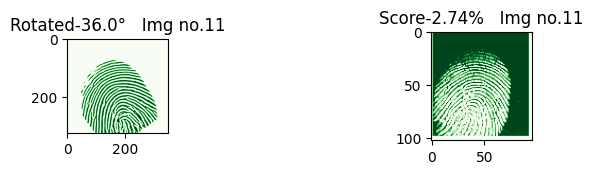

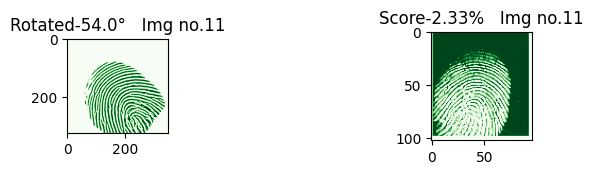

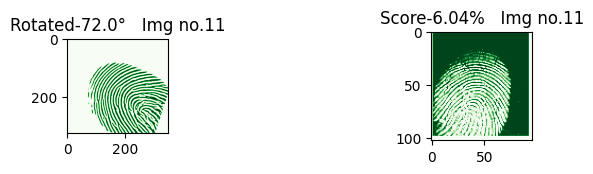

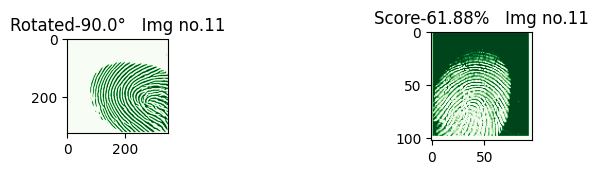

In [7]:
for j in range(0, 26, 5):
    
    bestscore = -1
    result = None
    
    M = np.float32([[1,0,rows*(j/100)],[0,1,cols*(j/100)]])
    rotate_matrix = cv2.getRotationMatrix2D(center=(rows/2, cols/2), angle=3.6*j, scale=1)
    changed_img = cv2.warpAffine(src=sample_img, M=rotate_matrix, dsize=(rows, cols))
#     changed_img = cv2.cvtColor(changed_img,cv2.COLOR_BGR2GRAY)
#     changed_img = image_enhancer.enhance(changed_img)
#     changed_img = np.array(changed_img, dtype=np.uint8)*255
    keypoints_2, descriptors_2 = sift.detectAndCompute(changed_img, None)
    c_map = None 

    for i in range(len(SIFT_DATA)):
        matches = cv2.FlannBasedMatcher(dict(algorithm=1, trees=10),
                                        dict()).knnMatch(SIFT_DATA[i][2], descriptors_2, k=2)
        match_points = []
        for p, q in matches:
            if p.distance < 0.1*q.distance:
                match_points.append(p)

        keypoints = min(len(SIFT_DATA[i][1]), len(keypoints_2))
        if len(match_points)/keypoints*100 > bestscore:
            bestscore = len(match_points)/keypoints*100
            result = i
    
#     print(" Score: " + str(bestscore) + " " + str(result) + " " + str(num))
    if result==num : 
        c_map = 'Greens'
    else:
        c_map = 'Reds'
        
    out = cv2.imread(os.path.join(folder, SIFT_DATA[result][0]))
#     out = cv2.cvtColor(out,cv2.COLOR_BGR2GRAY)
#     out = image_enhancer.enhance(out)
#     out = np.array(out, dtype=np.uint8)*255
    f = plt.figure(figsize=(6,3))
    sp = f.add_subplot(1, 4, 1)
#     plt.imshow(cv2.cvtColor(changed_img, cv2.COLOR_BGR2GRAY),cmap=c_map)
    plt.title("Rotated-{}°   Img no.{}".format(3.6*j, num))
    plt.imshow(changed_img ,cmap=c_map)
    sp = f.add_subplot(1, 4, 4)
    plt.title("Score-{0:1.2f}%   Img no.".format(bestscore)+str(result))
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2GRAY),cmap=c_map)